In [ ]:
!pip install ipympl
!pip install trimesh
!pip install -U scikit-learn
!python -m pip install scipy

In [1]:
%matplotlib ipympl
import numpy as np
import scipy.spatial as sp
import trimesh
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import multiprocessing
from sklearn.neighbors import NearestNeighbors

workers = multiprocessing.cpu_count()
np.set_printoptions(linewidth=100)

In [2]:
num_of_frames = 30

point_clouds = []
# Carregando todas as point clouds
for index in range(0, num_of_frames):
    # Usando operador ternario para avaliar se é necessário o 0 a mais
    file_name = "./KITTI-Sequence/0000"+ (("0" + str(index)) if index < 10 else str(index) )+"_points.obj"
    point_cloud = trimesh.load(file_name).vertices
    point_clouds.append(point_cloud)

In [90]:
def icp(source_points, target_points, epsilon = 1e-7, leafsize = 1, balanced_tree=True, max_iter = 100):

    def register_points(a, b):
        a1 = np.column_stack((a,np.ones(a.shape[0])))
        b1 = np.column_stack((b,np.ones(b.shape[0])))

        matrixA = np.tensordot(a1,a1.T,axes=[0,1])
        matrixR = np.tensordot(a1,b1.T,axes=[0,1])
        matrixAinv = np.linalg.inv(matrixA)
        return np.tensordot(matrixAinv,matrixR,axes=1).transpose() 

    '''
    def register_points(source, target):
        # source.shape == (N x 3)
        # target.shape == (M x 3)

        # cm = center of mass
        source_cm = np.average(source, axis=0).reshape((3,1)) # (3,1)
        target_cm = np.average(target, axis=0).reshape((3,1)) # (3,1)

        # mr = mean-reduced
        source_mr = source - source_cm.T
        target_mr = target - target_cm.T

        #H = np.sum(target_mr @ source_mr.T)

        # t = target_cm - R @ source_cm
        H = np.zeros((3, 3))
        for s, t in zip(source_mr, target_mr):
            #print(t, s)
            #print(np.outer(t,s))
            H += np.outer(t, s)
        
        U, D, Vh = np.linalg.svd(H)
        
        # R = VU.T
        R = Vh.T @ U.T
        t = target_cm - R @ source_cm
        tm = np.eye(4,4)
        tm[:3, :3] = R
        tm[:3, 3] = t.T
        return tm
    '''

    '''
    def register_points(p1, p2):
        u1 = np.mean(p1.T, axis=1).reshape((3, 1))
        u2 = np.mean(p2.T, axis=1).reshape((3, 1))
        pp1 = p1.T - u1
        pp2 = p2.T - u2
        
        W = np.dot(pp1, pp2.T)
        U, _, Vh = np.linalg.svd(W)
        R = np.dot(U, Vh).T
        if np.linalg.det(R) < 0:
            Vh[2, :] *= -1
            R = np.dot(U, Vh).T
        t = u2 - np.dot(R, u1)
        tm = np.eye(4,4)
        tm[:3, :3] = R
        tm[:3, 3] = t.T
        #print(tm)
        return tm
    '''
        
    # Keeping original points untouched

    source_copy = source_points.copy()
    source_copy = np.column_stack((source_copy,np.ones(source_copy.shape[0])))
    target_copy = target_points.copy()
    target_copy = np.column_stack((target_copy,np.ones(target_copy.shape[0])))
    
    current_points = source_points.copy()
    rmse = 1000000
    last_rmse = 0

    transformation_matrix = np.eye(4)
    i = 0
    kdt = sp.KDTree(target_points, leafsize = leafsize, balanced_tree=balanced_tree, copy_data=False)
    
    while i < max_iter:
        # Input has to be of shape (N, M) where
        # N = Number of points
        # M = dimensions
        # Thus the transpose is used
        _, indexes = kdt.query(current_points, k = 1, workers = workers)
        #print(indexes.shape, target_points.shape, current_points.shape)
        # Getting position of queried points
        target_selected = target_points[indexes, :]
        # Calculating transformation Matrix
        transformation_matrix = register_points(current_points, target_selected) @ transformation_matrix
        #transformation_matrix[-1, :3] = 0
        #transformation_matrix[-1,-1] = 1
        #print(transformation_matrix)

        # Updating current points
        predicted_points = np.dot(transformation_matrix, source_copy.T).T
        #predicted_points = []
        #for pt in source_copy:
        #    predicted_points.append(transformation_matrix @ pt)

        #predicted_points = np.asarray(predicted_points)
        # Calculating RMSE
        #print(predicted_points.T.shape, target_selected.shape)
        rmse = np.sqrt(np.mean(np.sum((predicted_points[:, :3] - target_selected[:, :3]) ** 2, axis=None)))

        if np.abs(rmse - last_rmse) < epsilon:
            break
    
        current_points = predicted_points[:, :3]
        last_rmse = rmse
        i += 1
    
    return transformation_matrix, rmse
        
        

0 44.37989830906131
1 40.86655939829844
2 43.616130935338994
3 40.232540238529026
4 41.73276185793276
5 48.91777688724948
6 50.05836871317129
7 38.45929833604489
8 48.99242175807191
9 65.51053722932139
10 38.99630816894951
11 40.22336479924006
12 48.65692669747031
13 43.738645728876726
14 58.56377660929916
15 63.52135855683603
16 70.43028357780317
17 51.336482374591704
18 62.41007833380709
19 132.39300168539404
20 46.66387291184253
21 58.06325333001375
22 51.863538919193715
23 62.92182457535726
24 45.15906058420343
25 61.06435695679039
26 76.84107910327904
27 65.69065281186295
28 150.60325061101557


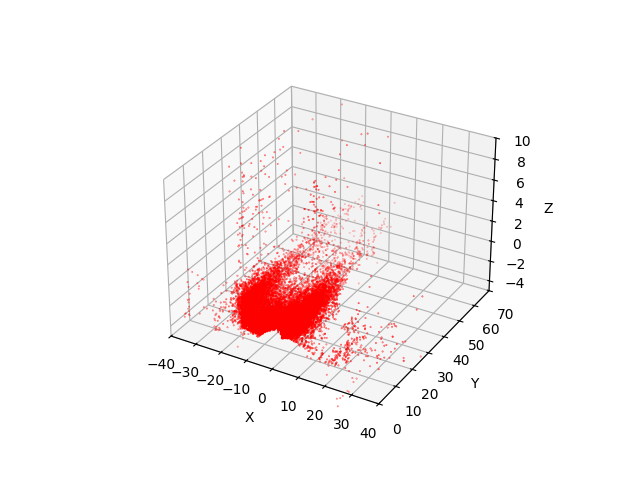

In [97]:
t_matrices = []
aligned_pc = []
aligned_pc.append(np.column_stack((point_clouds[0],np.ones(point_clouds[0].shape[0]))))
ax = plt.figure().add_subplot(projection='3d')
colors = ['red']
for i in range(num_of_frames - 1):
    tm, rmse = icp(point_clouds[i], point_clouds[i+1], epsilon=1e-6)
    print(i, rmse)
    p = np.column_stack((point_clouds[i+1],np.ones(point_clouds[i+1].shape[0])))
    #print(tm)
    p = np.array([np.linalg.inv(tm) @ q for q in p])
    size = p.shape[0]
    choices = np.random.choice(size, size=2000, replace=False)
    #print(p)
    x = p.T[0][choices]
    y = p.T[1][choices]
    z = p.T[2][choices]
    ax.scatter(x, y, z, s=0.1, c=colors[i % len(colors)])
    
    #print(p[0], "\n=============")
    #print(p, "\n=========================\n")
    aligned_pc.append(p)
    t_matrices.append(np.linalg.inv(tm))

#ax.legend()
#ax.plot(*pos_to_plot_truth, c='magenta')
#ax.plot(*pos_to_plot, c='orange')

ax.set_xlim(-40, 40)
ax.set_ylim(0, 70)
ax.set_zlim(-5, 10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
t_matrices

[[ 9.99981624e-01  5.98405606e-03 -4.11901796e-03 -3.56480241e-02]
 [ 4.56016718e-03  1.01124738e+00 -3.87532491e-01 -7.09745325e-01]
 [ 6.71287498e-04 -3.60784207e-04  1.00058029e+00 -3.36094254e-04]
 [-1.30395372e-16 -2.11167727e-16 -1.13970223e-15  1.00000000e+00]] 


[[ 1.00004413e+00 -5.91710969e-03  1.82506842e-03  3.14505698e-02]
 [-4.76741992e-03  9.89042582e-01  3.83044221e-01  7.01927139e-01]
 [-6.72646803e-04  3.60593775e-04  9.99556936e-01  5.67896560e-04]
 [ 1.28627785e-16  2.08493280e-16  1.22032182e-15  1.00000000e+00]]
 [-9.056182 17.949978  0.888338  1.      ]
[-9.12972183 18.83866709  0.90107657  1.        ]
 [-9.106149 17.908581  0.887326  1.      ]
[-9.17944793 18.79757427  0.9000837   1.        ]
 [-9.184107 17.92219   0.889309  1.      ]
[-9.25748628 18.81216538  0.90212317  1.        ]
 [-9.03208  17.089552  0.862305  1.      ]
[-9.10057504 17.97758244  0.87472863  1.        ]
 [-9.042068 17.043352  0.8603    1.      ]
[-9.11029377 17.93116829  0.87271457  1.    

/tmp/ipykernel_13463/1615866334.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


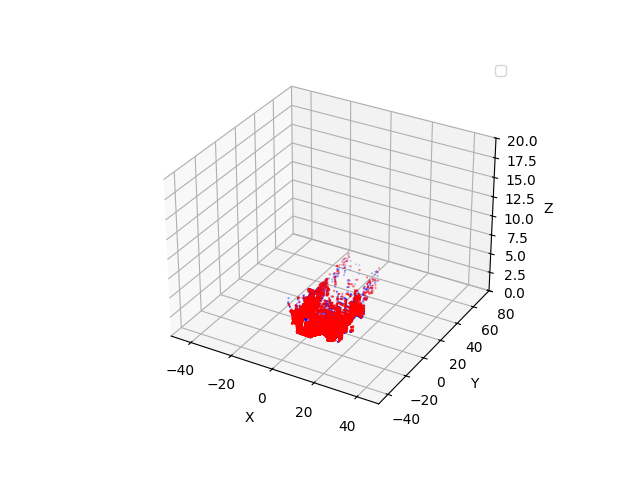

In [105]:
frame1 = 0
frame2 = 1

tm, _ = icp(point_clouds[frame1], point_clouds[frame2], epsilon=1e-50, max_iter = 500)
print(tm, "\n\n")
print(np.linalg.inv(tm))

ax = plt.figure().add_subplot(projection='3d')

size = len(point_clouds[frame1])
choices = np.random.choice(size, size=20000, replace=False)
x = point_clouds[frame1].T[0][choices]
y = point_clouds[frame1].T[1][choices]
z = point_clouds[frame1].T[2][choices]
ax.scatter(x, y, z, zdir='z', s=0.3, c='red')

pts = np.append(point_clouds[frame2], [[1]] * point_clouds[frame2].shape[0], axis = 1)

size = len(point_clouds[frame2])
choices = np.random.choice(size, size=20000, replace=False)

x = pts.T[0][choices]
y = pts.T[1][choices]
z = pts.T[2][choices]
#ax.scatter(x, y, z, zdir='z', s=0.1, c='yellow')

for p in pts[:10]:
    print("=======\n", p)
    print(np.linalg.inv(tm) @ p)
pts = np.array([np.linalg.inv(tm) @ q for q in pts]).T

#p = p.T


size = len(point_clouds[frame2])
choices = np.random.choice(size, size=20000, replace=False)

x = pts[0][choices]
y = pts[1][choices]
z = pts[2][choices]
ax.scatter(x, y, z, zdir='z', s=0.1, c='blue')
#ax.plot(*pos_to_plot_truth, c='blue')
#ax.plot(*pos_to_plot, c='orange')

ax.legend()

ax.set_xlim(-50, 50)
ax.set_ylim(-50, 80)
ax.set_zlim(0, 20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [98]:
real_position = np.eye(4,4)
groun_truth_transformation_matrix = np.load("./ground_truth.npy")
print(groun_truth_transformation_matrix)
ground_truth_positions = []

lidar_position = np.eye(4,4)
positions = []

positions.append(lidar_position)
for tm, gt in zip(t_matrices, groun_truth_transformation_matrix):
    real_position = gt @ real_position
    ground_truth_positions.append(real_position)
    print(tm)
    lidar_position = tm @ lidar_position
    positions.append(lidar_position)

positions = np.array(positions)
ground_truth_positions = np.array(ground_truth_positions)
pos_to_plot_truth = ground_truth_positions[:,:3,3].T
pos_to_plot = positions[:,:3,3].T
#print(positions)

[[[ 1.000000e+00  9.043680e-12  2.326809e-11  5.551115e-17]
  [ 9.043683e-12  1.000000e+00  2.392370e-10  3.330669e-16]
  [ 2.326810e-11  2.392370e-10  9.999999e-01 -4.440892e-16]
  [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]

 [[ 9.999978e-01  5.272628e-04 -2.066935e-03 -4.690294e-02]
  [-5.296506e-04  9.999992e-01 -1.154865e-03 -2.839928e-02]
  [ 2.066324e-03  1.155958e-03  9.999971e-01  8.586941e-01]
  [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]

 [[ 9.999910e-01  1.048972e-03 -4.131348e-03 -9.374345e-02]
  [-1.058514e-03  9.999968e-01 -2.308104e-03 -5.676064e-02]
  [ 4.128913e-03  2.312456e-03  9.999887e-01  1.716275e+00]
  [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]

 [[ 9.999796e-01  1.566466e-03 -6.198571e-03 -1.406429e-01]
  [-1.587952e-03  9.999927e-01 -3.462706e-03 -8.515762e-02]
  [ 6.193102e-03  3.472479e-03  9.999747e-01  2.574964e+00]
  [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]

 [[ 9.999637e-01  2.078471e-03 -

/tmp/ipykernel_13463/2234750756.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, zdir='z', s=0.3, c=color)
/tmp/ipykernel_13463/2234750756.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


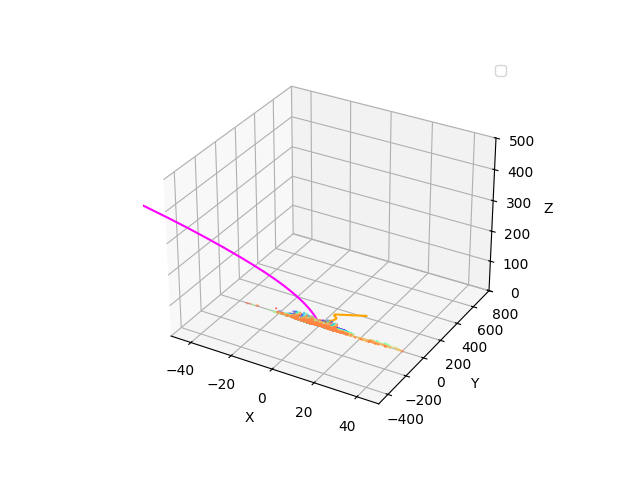

In [99]:
ax = plt.figure().add_subplot(projection='3d')
pts_to_show = list([point_clouds[n] for n in range(num_of_frames)])
#pts_to_show = list([point_clouds[n] for n in [0, 1]])
colors = cm.rainbow(np.linspace(0, 1, len(pts_to_show)))
for color, point_cloud in zip(colors, pts_to_show):
    size = len(point_cloud.T[0])
    choices = np.random.choice(size, size=1000, replace=False)
    x = point_cloud.T[0][choices]
    y = point_cloud.T[1][choices]
    z = point_cloud.T[2][choices]
    ax.scatter(x, y, z, zdir='z', s=0.3, c=color)

ax.legend()
ax.plot(*pos_to_plot_truth, c='magenta')
ax.plot(*pos_to_plot, c='orange')

ax.set_xlim(-50, 50)
ax.set_ylim(-500, 800)
ax.set_zlim(0, 500)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

/tmp/ipykernel_13463/254296196.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


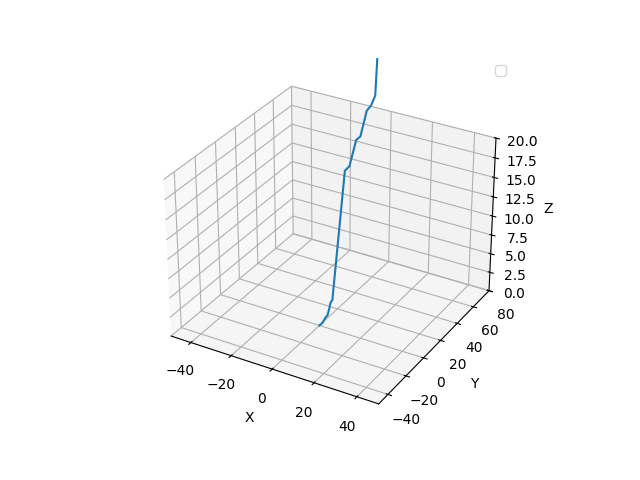

In [100]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pos_to_plot = positions[:,:3,3].T
ax.plot(*pos_to_plot)
#ax.plot(*positions[:,:3,3])
ax.legend()
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 80)
ax.set_zlim(0, 20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

/tmp/ipykernel_13463/1909506114.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


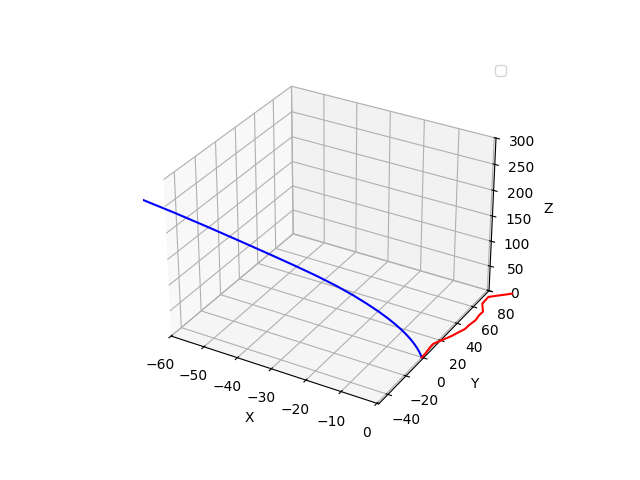

In [101]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pos_to_plot_truth = ground_truth_positions[:,:3,3].T
ax.plot(*pos_to_plot_truth, c='blue')
ax.plot(*pos_to_plot, c='red')
ax.legend()
ax.set_xlim(-60, 0.5)
ax.set_ylim(-50, 80)
ax.set_zlim(0, 300)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

/tmp/ipykernel_13463/401132373.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, zdir='z', s=0.1, c=color)
/tmp/ipykernel_13463/401132373.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


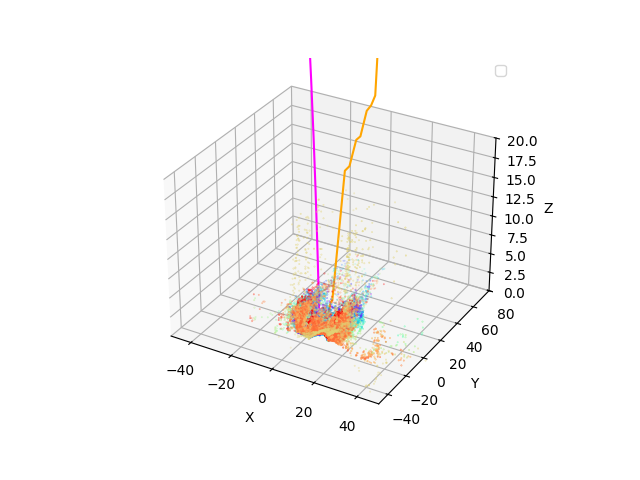

In [103]:
ax = plt.figure().add_subplot(projection='3d')
pts_to_show = list([aligned_pc[n] for n in range(len(aligned_pc))])
#pts_to_show = list([point_clouds[n] for n in [0, 1]])
colors = cm.rainbow(np.linspace(0, 1, len(pts_to_show)))
for color, apc in zip(colors, pts_to_show):
    size = len(apc.T[0])
    choices = np.random.choice(size, size=5000, replace=False)
    x = apc.T[0][choices]
    y = apc.T[1][choices]
    z = apc.T[2][choices]
    ax.scatter(x, y, z, zdir='z', s=0.1, c=color)

ax.legend()
ax.plot(*pos_to_plot_truth, c='magenta')
ax.plot(*pos_to_plot, c='orange')

ax.set_xlim(-50, 50)
ax.set_ylim(-50, 80)
ax.set_zlim(0, 20)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [104]:
print(np.linalg.inv(tm))

[[ 9.60623825e-01 -1.61930197e-02 -2.45448463e-01  1.21760900e-01]
 [ 1.89067032e-02  9.84766472e-01 -2.85848311e-01 -4.23381499e-01]
 [-3.44149179e-04  1.06895758e-02  5.89715200e-01 -7.50501870e-01]
 [-9.44152877e-17 -1.18476962e-15  4.30393319e-14  1.00000000e+00]]


In [51]:
src = [[10, 24, 3],
       [4, 55, 6],
       [7, 81, 9]]
src = np.asarray(src)
src.T

array([[10,  4,  7],
       [24, 55, 81],
       [ 3,  6,  9]])

In [52]:
trg = [[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]]
trg = np.asarray(trg)
trg.T

array([[1, 4, 7],
       [2, 5, 8],
       [3, 6, 9]])

In [58]:
H = np.zeros((3, 3))
for s, t in zip(src, trg):
    print(t, s)
    print(np.outer(t,s))
    H += np.outer(t, s)
H

[1 2 3] [10 24  3]
[[10 24  3]
 [20 48  6]
 [30 72  9]]
[4 5 6] [ 4 55  6]
[[ 16 220  24]
 [ 20 275  30]
 [ 24 330  36]]
[7 8 9] [ 7 81  9]
[[ 49 567  63]
 [ 56 648  72]
 [ 63 729  81]]


array([[  75.,  811.,   90.],
       [  96.,  971.,  108.],
       [ 117., 1131.,  126.]])

In [59]:
U, S, Vh = np.linalg.svd(H)
print(U)
print(S)
print(Vh)

[[-0.47757123  0.77798396  0.40824829]
 [-0.57216124  0.07723242 -0.81649658]
 [-0.66675125 -0.62351913  0.40824829]]
[1.71576244e+03 7.22923642e+00 6.72147306e-15]
[[-0.09835582 -0.9890498  -0.11003008]
 [-0.99438283  0.10202163 -0.02818448]
 [-0.0391013  -0.10663992  0.99352857]]


In [19]:
np.dot(trg, src)

array([[ 30,  36,  42],
       [ 66,  81,  96],
       [102, 126, 150],
       [138, 171, 204]])